# IQVIA Task

## Import Libraries and Data

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from functools import partial
import shap
from  utils import * 
from eda_functions import *
import optuna

## Import Data

In [6]:
metrics_df = pd.read_csv("metrics_data.csv")
test_df = pd.read_csv("tests_data.csv")

## Merge dataframes

In [7]:
# Merge both datasets based on 'Name'
main_df = df_merger(metrics_df,test_df)
main_df.head()

,Name,Age,BMI,Height,Label,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1
0,Huda Mcpherson,36.0,34.174890,163,1,80.0,6.590,1.300427,10.2809,5.065915,15.72187,581.313
1,Cassidy Hayes,75.0,30.480000,192,2,152.0,7.010,2.628283,50.5300,10.060000,11.73000,99.450
2,Arwen Kendall,78.0,25.300000,157,1,60.0,3.508,0.519184,6.6330,10.567295,4.66380,209.749
3,Nathanael Robin,45.0,21.303949,169,2,102.0,13.852,3.485163,7.6476,21.056625,23.03408,552.444
4,Theon Black,51.0,19.132653,193,2,93.0,NaN,1.001102,11.0816,5.807620,5.57055,90.600


## Changing Col name and label values
* label renamed to  target
* Values under label to be changed to 0 and 1 to be appropriate for binary classifications models downstream

In [10]:
main_df.rename(columns = {"Label":"target"},inplace=True)
main_df.head()

,Name,Age,BMI,Height,target,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1
0,Huda Mcpherson,36.0,34.174890,163,1,80.0,6.590,1.300427,10.2809,5.065915,15.72187,581.313
1,Cassidy Hayes,75.0,30.480000,192,2,152.0,7.010,2.628283,50.5300,10.060000,11.73000,99.450
2,Arwen Kendall,78.0,25.300000,157,1,60.0,3.508,0.519184,6.6330,10.567295,4.66380,209.749
3,Nathanael Robin,45.0,21.303949,169,2,102.0,13.852,3.485163,7.6476,21.056625,23.03408,552.444
4,Theon Black,51.0,19.132653,193,2,93.0,NaN,1.001102,11.0816,5.807620,5.57055,90.600


In [11]:
main_df["target"] = main_df["target"].replace([1,2],[0,1])

## Explore Dataframe

In [38]:
overview = ds_overview(main_df)
overview

,Feature,Cardinality,DataType,NanCount,NaN_%_of_Rows
0,Name,116,object,0,0.00000
1,Age,51,float64,5,0.04274
2,BMI,109,float64,1,0.00855
3,Height,41,int64,0,0.00000
4,target,2,int64,0,0.00000
5,Glucose,49,float64,1,0.00855
6,Insulin,110,float64,3,0.02564
7,HOMA,113,float64,3,0.02564
8,Leptin,114,float64,2,0.01709
9,Adiponectin,113,float64,2,0.01709


## Imputation
Will treat Age slightly differently

In [39]:
float64_list = overview[overview["DataType"]=="float64"]["Feature"].to_list()
float64_list.remove("Age")
float64_list

['BMI',
 'Glucose',
 'Insulin',
 'HOMA',
 'Leptin',
 'Adiponectin',
 'Resistin',
 'MCP.1']

In [40]:
main_df = df = mean_imputer(main_df,float64_list)
main_df

,Name,Age,BMI,Height,target,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1
0,Huda Mcpherson,36.0,34.174890,163,0,80.0,6.590000,1.300427,10.2809,5.065915,15.72187,581.313
1,Cassidy Hayes,75.0,30.480000,192,1,152.0,7.010000,2.628283,50.5300,10.060000,11.73000,99.450
2,Arwen Kendall,78.0,25.300000,157,0,60.0,3.508000,0.519184,6.6330,10.567295,4.66380,209.749
3,Nathanael Robin,45.0,21.303949,169,1,102.0,13.852000,3.485163,7.6476,21.056625,23.03408,552.444
4,Theon Black,51.0,19.132653,193,1,93.0,10.128175,1.001102,11.0816,5.807620,5.57055,90.600
...,...,...,...,...,...,...,...,...,...,...,...,...
112,Caitlan Beard,57.0,34.838148,189,1,95.0,12.548000,2.940415,33.1612,2.364950,9.95420,655.834
113,Nabilah Mcgill,72.0,23.620000,165,1,105.0,4.420000,1.144780,21.7800,17.860000,4.82000,195.940
114,Mackenzie Devine,40.0,27.636054,173,1,103.0,2.432000,0.617890,14.3224,6.783870,26.01360,293.123
115,Angelica Stevens,52.0,30.801249,185,1,87.0,30.212000,6.483495,29.2739,6.268540,24.24591,764.667


### For Age will use a random forest model to impute values 


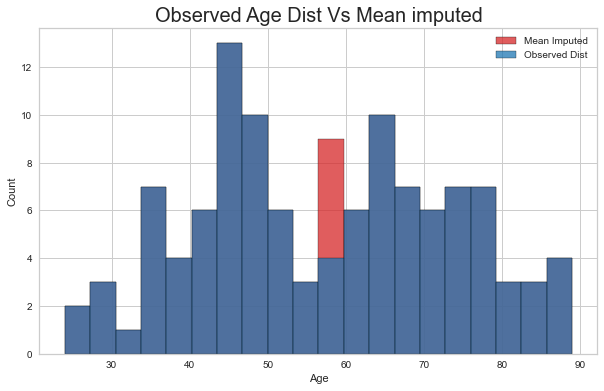

In [41]:
temp_df = main_df.copy()
temp_df["Age"].fillna(temp_df["Age"].mean(),inplace=True)
fig, axe = plt.subplots(figsize = (10,6))

sns.histplot(data=temp_df,x = "Age",bins = 20, label = "Mean Imputed",ax=axe,color="tab:red")
sns.histplot(data=main_df,x = "Age",bins = 20, label = "Observed Dist",ax=axe,color="tab:blue")

axe.set_title("Observed Age Dist Vs Mean imputed",size= 20)
axe.legend()

Text(0.5, 1.0, 'Correlations With Age')

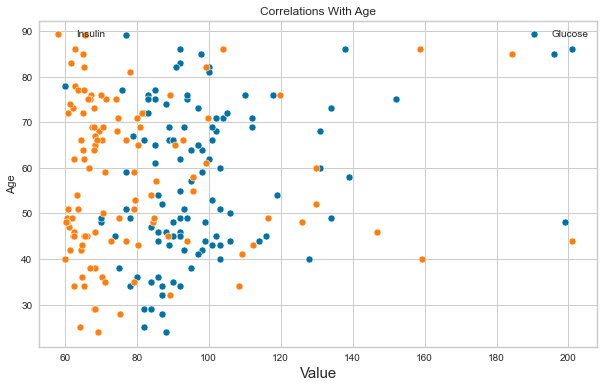

In [42]:
fig, axe = plt.subplots(figsize = (10,6))

sns.scatterplot(data = main_df,x = "Glucose", y = "Age",ax = axe,label = "Glucose")
axe2 = axe.twiny()

axe2 = sns.scatterplot(data = main_df,x = "Insulin", y = "Age",color="tab:orange",label = "Insulin")
axe2.axes.get_xaxis().set_visible(False)

axe.set_xlabel("Value",size = 15)

axe.legend(loc=0)
axe2.legend(loc=2)

axe.set_title(f"Correlations With Age")


In [ ]:
temp_df = main_df.copy()

#\split datframe into observations with Nan and not Nans under Age
#non Nans to train a random forest model

loc_filter = main_df["Age"].isna()==False
non_nan_df = main_df.loc[loc_filter,:]
nan_df = main_df.loc[~loc_filter,:]

#Define X and y
X = non_nan_df[["Glucose","Insulin"]].copy()
y= non_nan_df["Age"].copy()

rf = RandomForestClassifier()
rf.fit(X,y)

#impute into nan_df with model
nan_df.loc[:,"Age"] = rf.predict(nan_df.loc[:,["Glucose","Insulin"]])

# #stitching tables back together
temp_df = pd.concat([non_nan_df,nan_df])


In [44]:
ds_overview(main_df)

,Feature,Cardinality,DataType,NanCount,NaN_%_of_Rows
0,Name,116,object,0,0.00000
1,Age,51,float64,5,0.04274
2,BMI,110,float64,0,0.00000
3,Height,41,int64,0,0.00000
4,target,2,int64,0,0.00000
5,Glucose,50,float64,0,0.00000
6,Insulin,111,float64,0,0.00000
7,HOMA,114,float64,0,0.00000
8,Leptin,115,float64,0,0.00000
9,Adiponectin,114,float64,0,0.00000


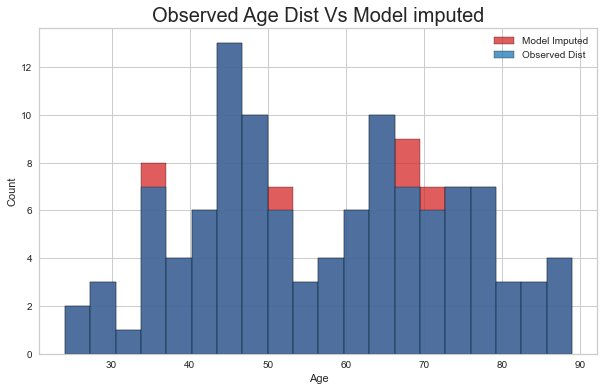

In [45]:
fig, axe = plt.subplots(figsize = (10,6))

sns.histplot(data=temp_df,x = "Age",bins = 20, label = "Model Imputed",ax=axe,color="tab:red")
sns.histplot(data=main_df,x = "Age",bins = 20, label = "Observed Dist",ax=axe,color="tab:blue")

axe.set_title("Observed Age Dist Vs Model imputed",size= 20)
axe.legend()

In [46]:
main_df = temp_df.copy()

# 1. Exploring the Dataset

### The proportion of patients with cancer that are below 50 years of age: 43.75%

In [14]:
cancer_df = main_df[main_df["target"]==1].copy()
cancer_df["<50"] = main_df["Age"]<50
piv = cancer_df.pivot_table(index = "<50", values = "target", aggfunc="count")
piv["%"] = piv["target"]/piv["target"].sum()*100
piv

,target,%
<50,,
False,36,56.25
True,28,43.75


### Standard deviation of resistin: 12.347

In [48]:
main_df.describe()

,Age,BMI,Height,target,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1
count,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000
mean,57.393162,27.552555,172.213675,0.547009,97.853448,10.128175,2.654952,26.628484,10.174528,14.773210,536.804842
std,16.173071,4.995516,12.367107,0.499926,22.432371,9.986361,3.559967,19.004471,6.829868,12.347701,343.309694
min,24.000000,18.370000,150.000000,0.000000,60.000000,2.432000,0.467409,4.311000,1.656020,3.210000,45.843000
25%,45.000000,23.000000,162.000000,0.000000,86.000000,4.427000,0.972138,12.450000,5.478170,6.892350,280.694000
50%,58.000000,27.552555,171.000000,1.000000,92.000000,6.107000,1.402626,21.211700,8.404430,10.960000,481.949000
75%,71.000000,31.238590,184.000000,1.000000,102.000000,10.949000,2.654952,35.891000,11.787960,18.355740,698.789000
max,89.000000,38.578759,194.000000,1.000000,201.000000,58.460000,25.050342,90.280000,38.040000,82.100000,1698.440000


### BMI Distribution for cancer patients

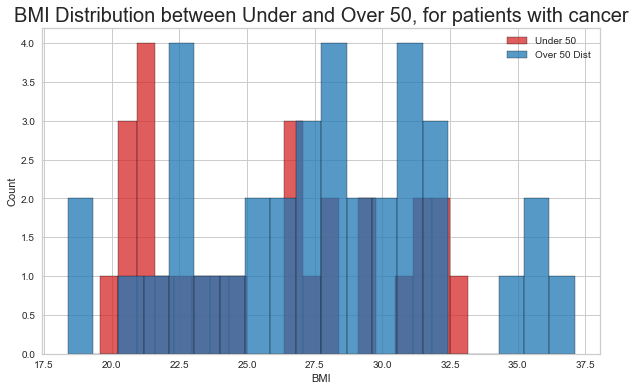

In [15]:
fig, axe = plt.subplots(figsize = (10,6))

sns.histplot(data=cancer_df[cancer_df["<50"]==True],x = "BMI",bins = 20, label = "Under 50",ax=axe,color="tab:red")
sns.histplot(data=cancer_df[cancer_df["<50"]==False],x = "BMI",bins = 20, label = "Over 50 Dist",ax=axe,color="tab:blue")

axe.set_title("BMI Distribution between Under and Over 50, for patients with cancer",size = 20)
axe.legend()

In [36]:
under_50_list = []

under_50_df = cancer_df[cancer_df["<50"]==True].copy()
for i in range(0,1000):
    sample = under_50_df.sample(frac = 0.3)
    mean = sample["BMI"].mean()
    under_50_list.append(mean)
    

In [19]:
over_50_list = []

over_50_df = cancer_df[cancer_df["<50"]==False].copy()
for i in range(0,1000):
    sample = over_50_df.sample(frac = 0.3)
    mean = sample["BMI"].mean()
    over_50_list.append(mean)



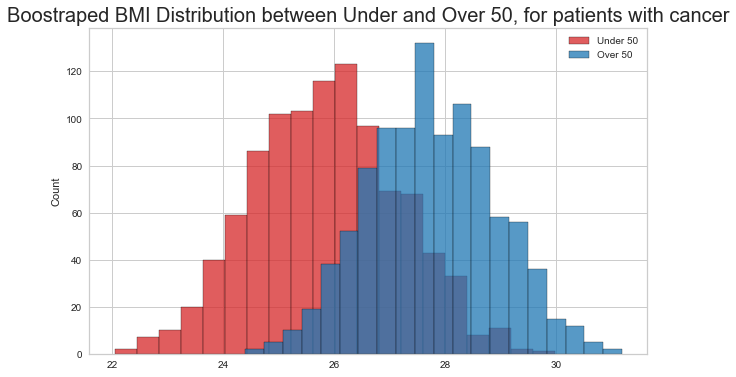

In [21]:
fig, axe = plt.subplots(figsize = (10,6))

sns.histplot(data=under_50_list, bins=20, label = "Under 50",ax=axe,color="tab:red")
sns.histplot(data=over_50_list, bins=20, label = "Over 50",ax=axe,color="tab:blue")

axe.set_title("Boostraped BMI Distribution between Under and Over 50, for patients with cancer",size = 20)
axe.legend()

### Distribution of BMI considering only the patients in the 50+ group who have increased fasting blood glucose (Glucose) and insulin (Insulin)

In [53]:
# Fasting blood glucose is normal numbers is anything lower than 110 and insulin lower than 7.8
IncIn_IncG_df = cancer_df.copy()
IncIn_IncG_df.loc[(IncIn_IncG_df["Glucose"]>110) & (IncIn_IncG_df["Insulin"]> 7.8)&(IncIn_IncG_df["<50"]==False),"High_Risk"] = True
IncIn_IncG_df["High_Risk"].fillna(False,inplace=True)
IncIn_IncG_df

,Name,Age,BMI,Height,target,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,<50,High_Risk
1,Cassidy Hayes,75.0,30.480000,192,1,152.0,7.010000,2.628283,50.5300,10.060000,11.73000,99.450,False,False
3,Nathanael Robin,45.0,21.303949,169,1,102.0,13.852000,3.485163,7.6476,21.056625,23.03408,552.444,True,False
4,Theon Black,51.0,19.132653,193,1,93.0,10.128175,1.001102,11.0816,5.807620,5.57055,90.600,False,False
5,Tahmina Carty,34.0,24.242424,177,1,92.0,21.699000,4.924226,16.7353,21.823745,12.06534,481.949,True,False
6,Connie Mcdougall,59.0,28.672626,187,1,77.0,10.128175,0.605507,17.0220,16.440480,31.69040,910.489,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,Mackenzie Devine,40.0,27.636054,173,1,103.0,2.432000,0.617890,14.3224,6.783870,26.01360,293.123,True,False
115,Angelica Stevens,52.0,30.801249,185,1,87.0,30.212000,6.483495,29.2739,6.268540,24.24591,764.667,False,False
116,Rajan Goldsmith,45.0,29.384757,166,1,90.0,4.713000,1.046286,23.8479,6.644245,15.55625,621.273,True,False
14,Ross O'Moore,68.0,18.370000,174,1,105.0,6.030000,1.561770,9.6200,12.760000,3.21000,513.660,False,False


In [54]:
over_50_HR_list = []

over_50_HR_df = IncIn_IncG_df[(IncIn_IncG_df["<50"]==False)&(IncIn_IncG_df["High_Risk"]==True)].copy()
for i in range(0,1000):
    sample = over_50_HR_df.sample(frac = 0.5)
    mean = sample["BMI"].mean()
    over_50_HR_list.append(mean)



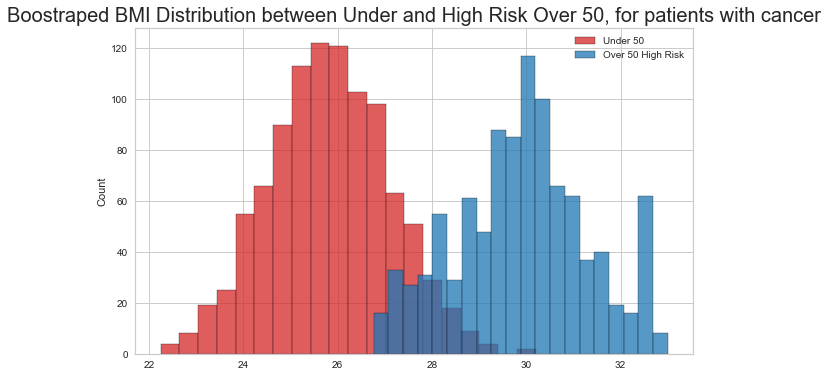

In [55]:
fig, axe = plt.subplots(figsize = (10,6))

sns.histplot(data=under_50_list,bins = 20, label = "Under 50",ax=axe,color="tab:red")
sns.histplot(over_50_HR_list,bins = 20, label = "Over 50 High Risk",ax=axe,color="tab:blue")

axe.set_title("Boostraped BMI Distribution between Under and High Risk Over 50, for patients with cancer",size = 20)
axe.legend()

In [56]:

#No high risk under 50? seems odd, but the data set is very small. 


under_50_HR_df = IncIn_IncG_df[(IncIn_IncG_df["<50"]==True)&(IncIn_IncG_df["High_Risk"]==True)].copy()
under_50_HR_df

,Name,Age,BMI,Height,target,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,<50,High_Risk


## Visualisations:
### Label distribution:
This can help to find out data imbalance - very common in medical datasets and outliers in the data

Text(0.5, 1.0, 'Cancer Percentage')

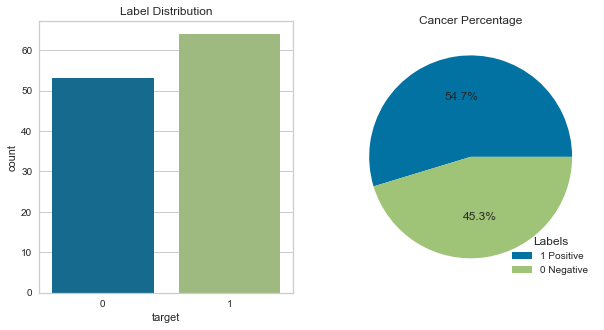

In [52]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5) )
#countplot
sns.countplot(ax=ax1, x=main_df['target'])
ax1.set_title("Label Distribution")

#piechart
ax2.pie(main_df['target'].value_counts(),autopct='%1.1f%%' )
ax2.legend(labels=['1 Positive', '0 Negative' ], title='Labels',loc='lower right')
ax2.set_title("Cancer Percentage")

In [48]:
main_df['target'].value_counts()

1    64
0    53
Name: target, dtype: int64

Text(0.5, 1.0, 'MCP.1')

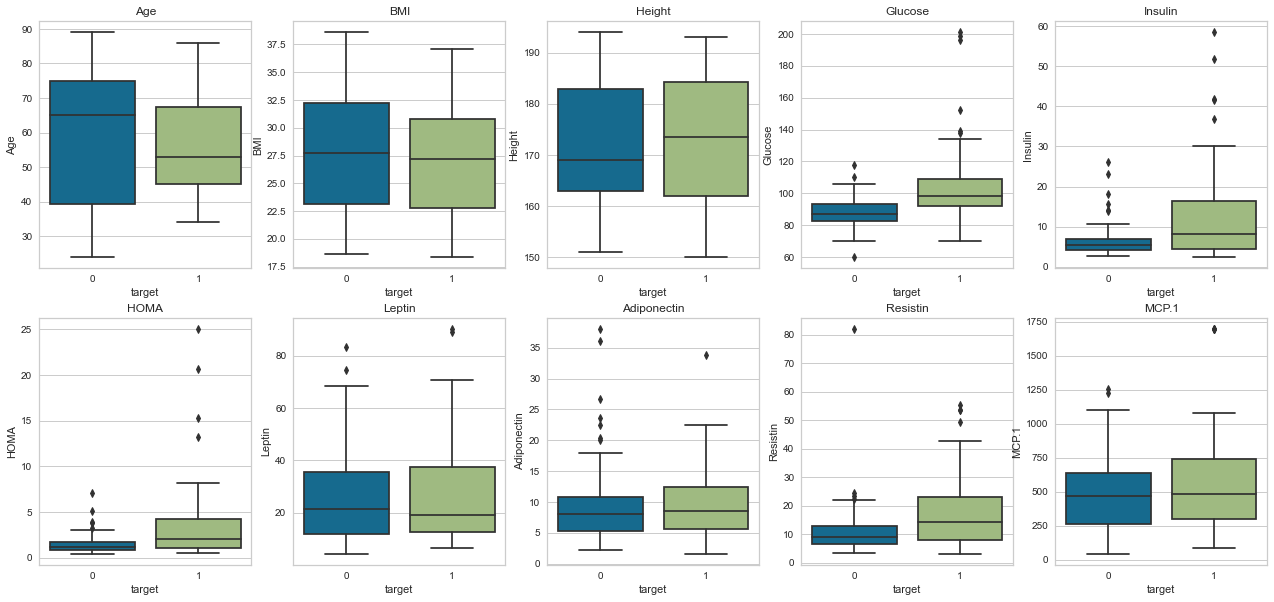

In [47]:
fig, axes = plt.subplots(2, 5, figsize=(22, 10), sharey=False)
#fig.suptitle('Boxplots for features')
sns.boxplot(ax=axes[0,0],x=main_df['target'], y=main_df['Age']).set_title("Age")
sns.boxplot(ax=axes[0,1],x=main_df['target'], y=main_df['BMI']).set_title("BMI")
sns.boxplot(ax=axes[0,2],x=main_df['target'], y=main_df['Height']).set_title("Height")
sns.boxplot(ax=axes[0,3],x=main_df['target'], y=main_df['Glucose']).set_title("Glucose")
sns.boxplot(ax=axes[0,4],x=main_df['target'], y=main_df['Insulin']).set_title("Insulin")

sns.boxplot(ax=axes[1,0],x=main_df['target'], y=main_df['HOMA']).set_title("HOMA")
sns.boxplot(ax=axes[1,1],x=main_df['target'], y=main_df['Leptin']).set_title("Leptin")
sns.boxplot(ax=axes[1,2],x=main_df['target'], y=main_df['Adiponectin']).set_title("Adiponectin")
sns.boxplot(ax=axes[1,3],x=main_df['target'], y=main_df['Resistin']).set_title("Resistin")
sns.boxplot(ax=axes[1,4],x=main_df['target'], y=main_df['MCP.1']).set_title("MCP.1")

histograms:
    

In [59]:
# sns.pairplot(data=cancer_df)

### Correlations

Text(0.5, 1.0, 'Pearson Correlation Matrix')

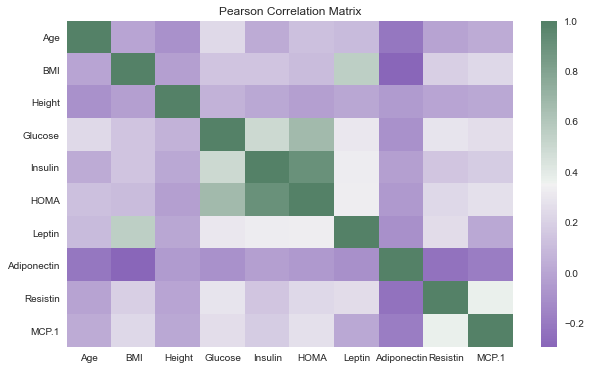

In [60]:
fig, axe = plt.subplots(figsize = (10,6))

colorMap = sns.diverging_palette(145, 280, s=50, l=50, n=200)
sns.heatmap(main_df.drop("target",axis=1).corr(), cmap = colorMap[::-1]) 

axe.set_title("Pearson Correlation Matrix")

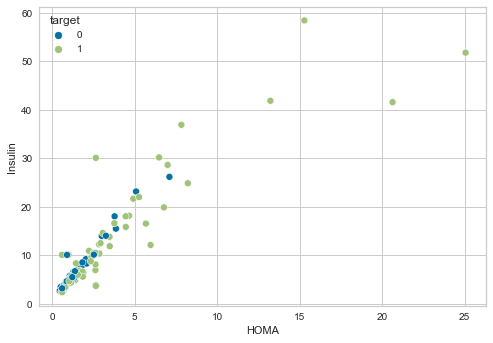

In [61]:
sns.scatterplot(x="HOMA", 
                y="Insulin",
                hue="target",
                data=main_df)

# 2. Creating a Model

### Some conclusions:

Handling outlieers will be an challenge for this dataset. But these will largely be driven by the fact the sample volume is so low. Features with observed outliers: Glucose, Insullin, HOMA, Adiponecting. 

Further, some of the data is skewed. Again, to what extend is this driven by low volumes, is unknown.

Classic linear models require data to be:
1 - normally distributed. 
2 - no multicollinearity between explanaroty variables. 
3 - linear relationship to exist between dependent and independent variables. 

The data have doesnt quite lend to be put through a logictic regression model. 

Instead of using a linear model, it is possible to use a more robust algorithm to model for propensity of developing cancer. For example, a gradient boosting models, such as XGboost. These models are non-linear ensembles of weak learners that do not depend on the same underlying assumptions of linear models. Since they are tree based, they do struggle to extrapolate. And, the score they return is not a probability (for a probability to be produced, the model needs to be calibrated)



## Preprocessing of the data

### Data Quality Assesment:
Most of the data pre-processing has already been done upstream. But, if a linear model was the choice:

- transform explanatory variables with quantile transformers, log-transfornmers etc. 
- standardise between 0 and 1
- drop features with high multicollinearity

With enough volume, the data would be split into:

1 - train
2 - test
3 - valid - to pass during tuning
4 - time hold out -  If time is a dimension (think its worth having eyes on)

given volume of the set, will do train and test only

### Baseline Model

In [63]:
# xgboost doesnt like certain special characters in the names of features 
main_df.rename(columns = {"<50":"below_50"},inplace=True)
main_df.head()


,Name,Age,BMI,Height,target,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1
0,Huda Mcpherson,36.0,34.174890,163,0,80.0,6.590000,1.300427,10.2809,5.065915,15.72187,581.313
1,Cassidy Hayes,75.0,30.480000,192,1,152.0,7.010000,2.628283,50.5300,10.060000,11.73000,99.450
2,Arwen Kendall,78.0,25.300000,157,0,60.0,3.508000,0.519184,6.6330,10.567295,4.66380,209.749
3,Nathanael Robin,45.0,21.303949,169,1,102.0,13.852000,3.485163,7.6476,21.056625,23.03408,552.444
4,Theon Black,51.0,19.132653,193,1,93.0,10.128175,1.001102,11.0816,5.807620,5.57055,90.600


In [64]:
X = main_df.drop(["Name","target"],axis=1)
y = main_df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [70]:
base_model = XGBClassifier()
base_model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=0, reg_alpha=0, ...)

d:\ProgramData\Anaconda3\envs\Offer_Management\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
d:\ProgramData\Anaconda3\envs\Offer_Management\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
d:\ProgramData\Anaconda3\envs\Offer_Management\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
d:\ProgramData\Anaconda3\envs\Offer_Management\li

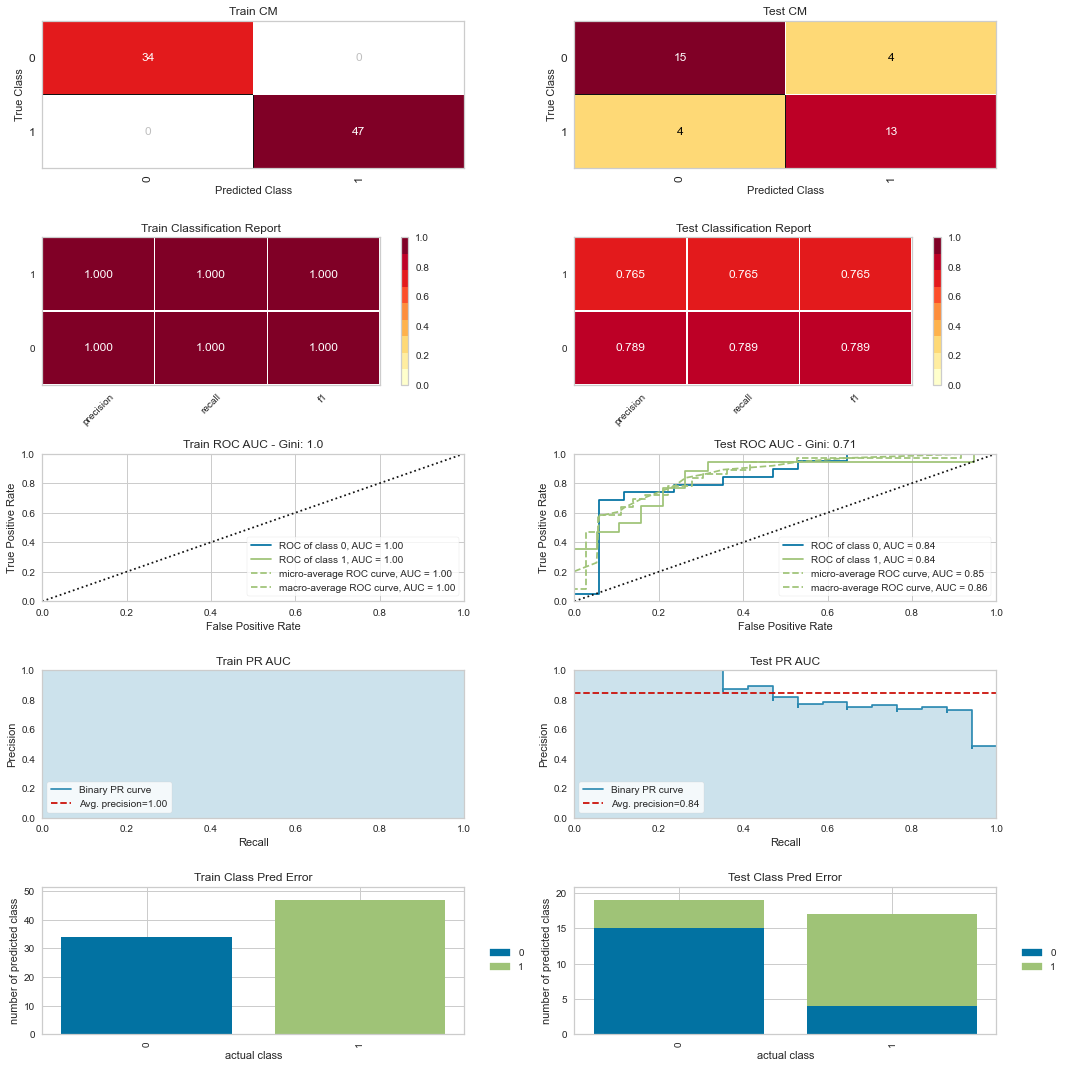

In [71]:
#Model overfits
plot_eval_metrics(base_model,X_train, y_train,X_test,y_test)

# Tuning

In [73]:
from sklearn.metrics import roc_auc_score

In [92]:
def objective(trial,X,y,eval_metric):
    
    param = {"verbosity": None,
            "objective": "binary:logistic",
            'max_depth' :trial.suggest_int("max_depth", 5, 10),
            'eta' : trial.suggest_loguniform("eta", 0.01, 0.03),
            'n_estimators' : trial.suggest_int('n_estimators', 10, 20),
            # 'min_child_weight': trial.suggest_int('min_child_weight', 400, 600),
            'gamma': trial.suggest_loguniform('gamma', 10, 15),
            # 'grow_policy': trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
            # "colsample_bytree": trial.suggest_uniform("colsample_bytree",0.4,1.0)
             }
    
    bst = XGBClassifier(**param,eval_metric=eval_metric, n_jobs = 35,use_label_encoder=False)
    
    bst.fit(X=X,y= y)
    
    preds = bst.predict(X)

    score = roc_auc_score(y,preds)
    
    return score


In [96]:
fmin_objective = partial(objective, 
                         X=X_train, 
                         y=y_train,
                        #  evalset=[X_eval,y_eval],
                         eval_metric = "auc")

# pruner = optuna.pruners.SuccessiveHalvingPruner()
pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)
study = optuna.create_study(pruner=pruner, direction="maximize")

study.optimize(fmin_objective, 
               n_trials=100)

print(study.best_params)

[I 2022-08-20 00:07:47,505] A new study created in memory with name: no-name-79f6d632-a9b1-4b8f-a540-f66891531f19
[I 2022-08-20 00:07:47,561] Trial 0 finished with value: 0.5 and parameters: {'max_depth': 6, 'eta': 0.014509625118397897, 'n_estimators': 18, 'gamma': 11.241506637804632}. Best is trial 0 with value: 0.5.
[I 2022-08-20 00:07:47,639] Trial 1 finished with value: 0.5 and parameters: {'max_depth': 7, 'eta': 0.0250442056138707, 'n_estimators': 15, 'gamma': 14.877226486271242}. Best is trial 0 with value: 0.5.
[I 2022-08-20 00:07:47,703] Trial 2 finished with value: 0.5 and parameters: {'max_depth': 8, 'eta': 0.018064530758345812, 'n_estimators': 14, 'gamma': 14.88145385409113}. Best is trial 0 with value: 0.5.
[I 2022-08-20 00:07:47,748] Trial 3 finished with value: 0.7769086357947435 and parameters: {'max_depth': 5, 'eta': 0.02760691850618026, 'n_estimators': 11, 'gamma': 10.019094387709348}. Best is trial 3 with value: 0.7769086357947435.
[I 2022-08-20 00:07:47,798] Trial 4 

{'max_depth': 9, 'eta': 0.018001022816133992, 'n_estimators': 10, 'gamma': 10.010167488738384}


In [97]:
best_model = XGBClassifier(**study.best_params)
best_model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.018001022816133992, eval_metric=None,
              gamma=10.010167488738384, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.0180010237, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=10, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=0, ...)

d:\ProgramData\Anaconda3\envs\Offer_Management\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
d:\ProgramData\Anaconda3\envs\Offer_Management\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
d:\ProgramData\Anaconda3\envs\Offer_Management\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
d:\ProgramData\Anaconda3\envs\Offer_Management\li

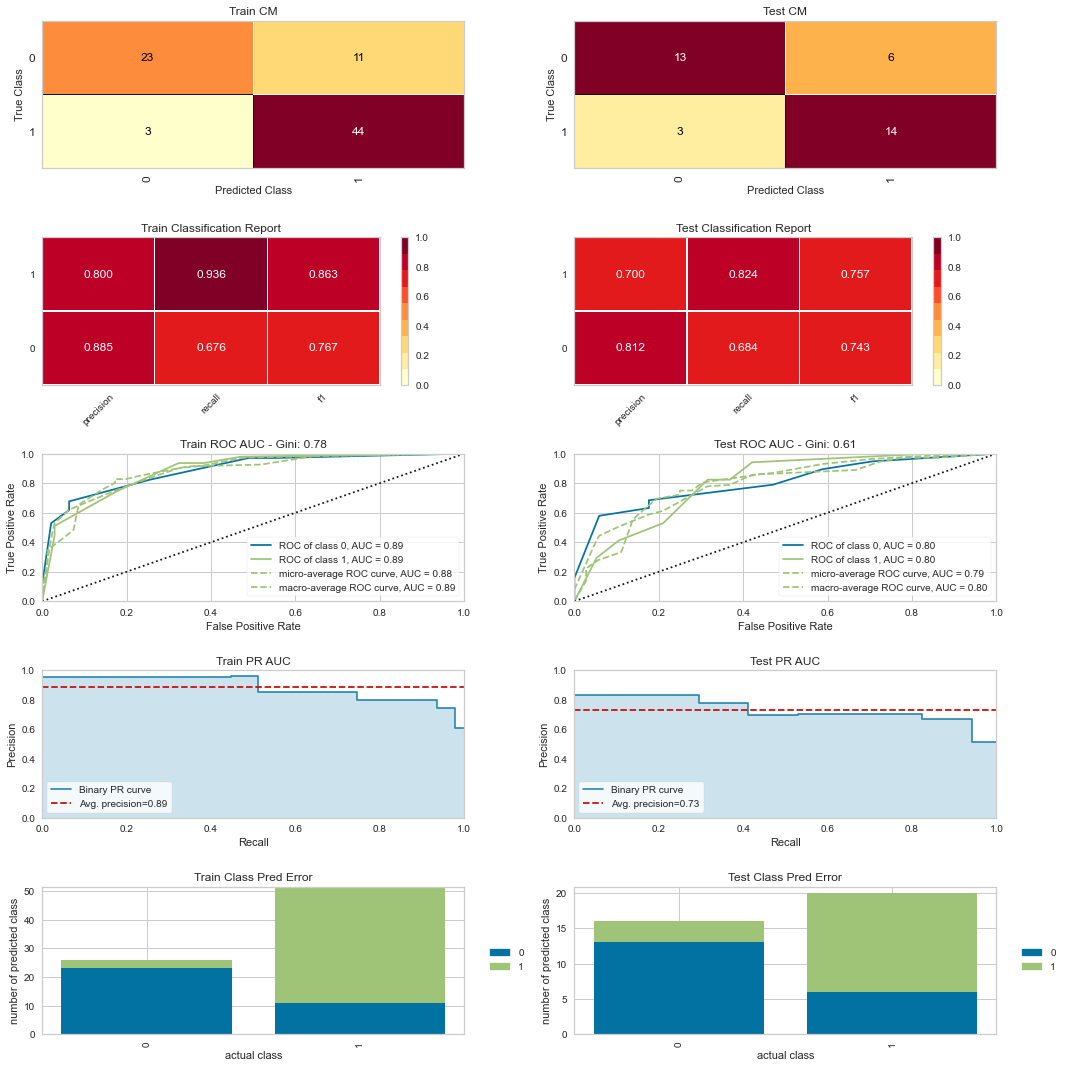

In [98]:

plot_eval_metrics(best_model,X_train, y_train,X_test,y_test)

In [100]:
shap.initjs()
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


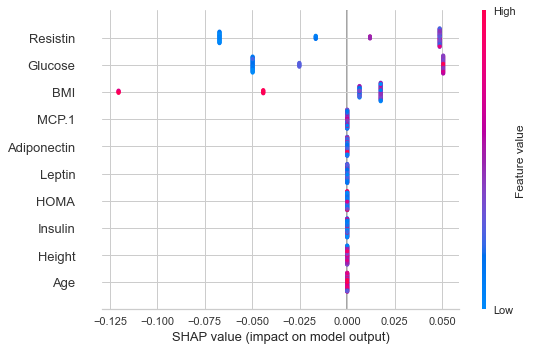

Text(0.5, 1.0, 'Shap Values')

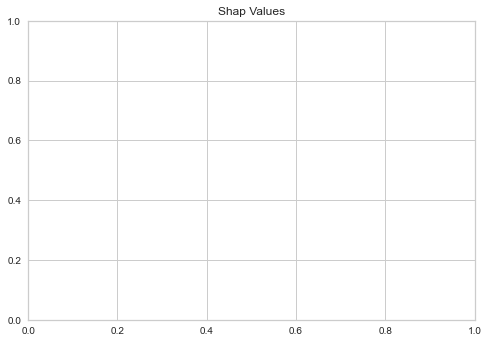

In [105]:
shap.summary_plot(shap_values, X_train)
plt.title("Shap Values")
# plt.tight_layout()
# plt.show()